In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image, ImageOps
import requests
import torch
import matplotlib.pyplot as plt
import numpy as np

import torch
import requests
from tqdm import tqdm
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline
import torchvision.transforms as T

from utils import preprocess, prepare_mask_and_masked_image, recover_image

In [2]:
to_pil = T.ToPILImage()

### First lets instantiate an inpainting stable diffusion model

In [3]:
# make sure you're logged in with `huggingface-cli login` - check https://github.com/huggingface/diffusers for more details

pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained(
    # "runwayml/stable-diffusion-inpainting",
    "stabilityai/stable-diffusion-2-inpainting",
    # revision="fp16",
    torch_dtype=torch.float16,
)
pipe_inpaint = pipe_inpaint.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

### The image to immunize
Now let's load image + some mask so that we can inpaint the rest!

In [10]:
init_image = Image.open(f'../assets/trevor_5.jpg').convert('RGB').resize(
    (512, 512)
)
mask_image = Image.open(f'../assets/trevor_5.tif').convert('RGB')
mask_image = ImageOps.invert(mask_image).resize((512, 512))

init_image

KeyboardInterrupt: 

### Simple attack implementation
Now we implement a simple PGD attack 

In [ ]:
def pgd(
    X,
    target,
    model,
    criterion,
    eps=0.1,
    step_size=0.015,
    iters=40,
    clamp_min=0,
    clamp_max=1,
    mask=None
):
  X_adv = X.clone().detach() + (torch.rand(*X.shape) * 2 * eps - eps).cuda()
  pbar = tqdm(range(iters))
  for i in pbar:
    actual_step_size = step_size - (step_size - step_size / 100) / iters * i
    X_adv.requires_grad_(True)

    loss = (model(X_adv).latent_dist.mean - target).norm()

    pbar.set_description(
        f"[Running attack]: Loss {loss.item():.5f} | step size: {actual_step_size:.4}"
    )

    grad, = torch.autograd.grad(loss, [X_adv])

    X_adv = X_adv - grad.detach().sign() * actual_step_size
    X_adv = torch.minimum(torch.maximum(X_adv, X - eps), X + eps)
    X_adv.data = torch.clamp(X_adv, min=clamp_min, max=clamp_max)
    X_adv.grad = None

    if mask is not None:
      X_adv.data *= mask

  return X_adv

### Target image
Here, different from the img2img notebook, we will attack the image towards the embedding of some random target image from the internet!

You can still effectively attack towards an embedding of zeros too! 

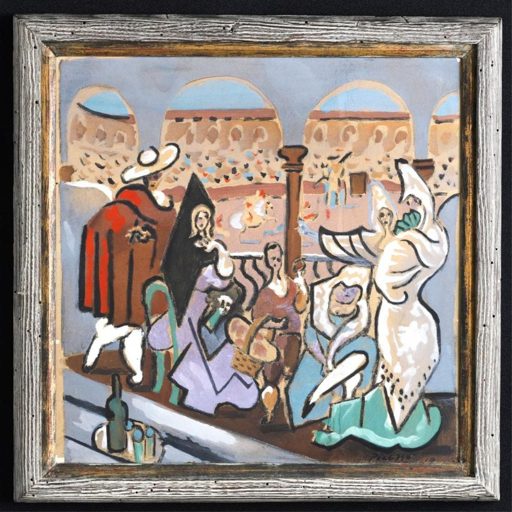

In [6]:
target_url = "https://bostonglobe-prod.cdn.arcpublishing.com/resizer/2-ZvyQ3aRNl_VNo7ja51BM5-Kpk=/960x0/cloudfront-us-east-1.images.arcpublishing.com/bostonglobe/CZOXE32LQQX5UNAB42AOA3SUY4.jpg"

response = requests.get(target_url)
target_image = Image.open(BytesIO(response.content)).convert("RGB")
target_image = target_image.resize((512, 512))
target_image



### Executing the attack
Now we apply the attack to our image

In [ ]:
with torch.autocast('cuda'):
  mask, X = prepare_mask_and_masked_image(init_image, mask_image)
  X = X.half().cuda()
  mask = mask.half().cuda()

  # Here we attack towards the embedding of a random target image. You can also simply attack towards an embedding of zeros!
  target = pipe_inpaint.vae.encode(
      preprocess(target_image).half().cuda()
  ).latent_dist.mean

  adv_X = pgd(
      X,
      target=target,
      model=pipe_inpaint.vae.encode,
      criterion=torch.nn.MSELoss(),
      clamp_min=-1,
      clamp_max=1,
      eps=0.06,
      step_size=0.01,
      iters=1000,
      mask=1 - mask
  )

  adv_X = (adv_X / 2 + 0.5).clamp(0, 1)

[Running attack]: Loss 607.11682 | step size: 0.0001099: 100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]


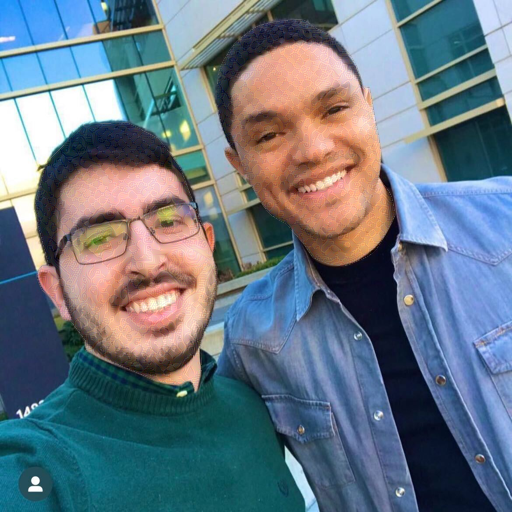

In [8]:
adv_image = to_pil(adv_X[0]).convert("RGB")
adv_image = recover_image(adv_image, init_image, mask_image, background=True)
adv_image

In [9]:
raise ValueError("This is a dummy cell to prevent running the following cells")

ValueError: This is a dummy cell to prevent running the following cells

### Running Stable Diffusion Inpainting
Now that we generated an "immunized"/adversarial image, lets try to run inpainting using stable diffusion on both the original and the adversarial images

In [ ]:
# prompt = "man riding a motorcycle at night"
# prompt = "two men in a wedding"
# prompt = "two men in a restaurant hugging"
# prompt = "two men in a classroom"
# prompt = "two men in a library"
prompt = "two men in the plane hugging"

# A good seed
SEED = 9209

# Uncomment the below to generated other images
# SEED = np.random.randint(low=0, high=100000)

torch.manual_seed(SEED)
print(SEED)

strength = 0.7
guidance_scale = 7.5
num_inference_steps = 100

image_nat = pipe_inpaint(
    prompt=prompt,
    image=init_image,
    mask_image=mask_image,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=strength
).images[0]
image_nat = recover_image(image_nat, init_image, mask_image)

torch.manual_seed(SEED)
image_adv = pipe_inpaint(
    prompt=prompt,
    image=adv_image,
    mask_image=mask_image,
    eta=1,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    strength=strength
).images[0]
image_adv = recover_image(image_adv, init_image, mask_image)

9209


  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

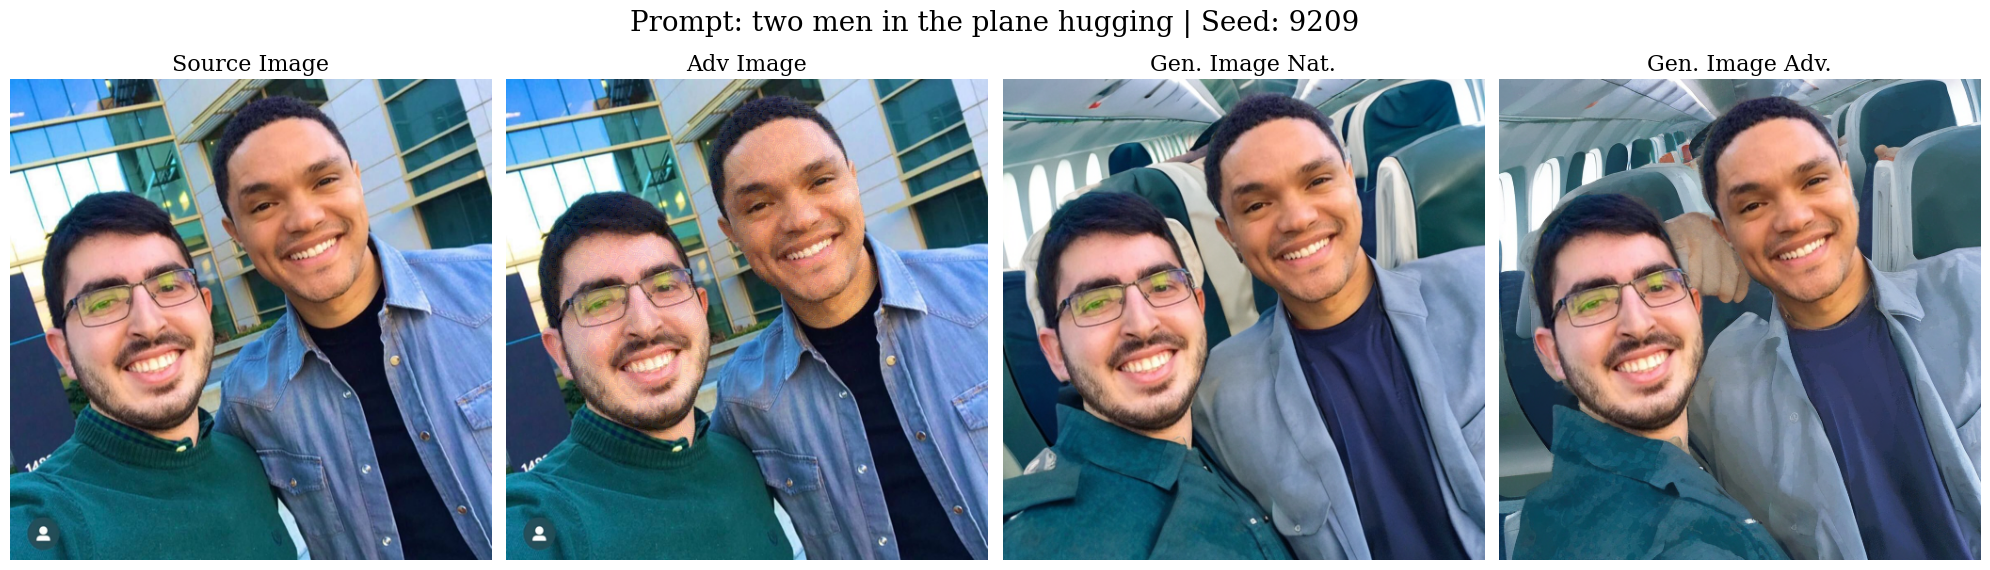

In [ ]:
adv_image = recover_image(adv_image, init_image, mask_image, background=True)
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))

ax[0].imshow(init_image)
ax[1].imshow(adv_image)
ax[2].imshow(image_nat)
ax[3].imshow(image_adv)

ax[0].set_title('Source Image', fontsize=16)
ax[1].set_title('Adv Image', fontsize=16)
ax[2].set_title('Gen. Image Nat.', fontsize=16)
ax[3].set_title('Gen. Image Adv.', fontsize=16)

for i in range(4):
  ax[i].grid(False)
  ax[i].axis('off')

fig.suptitle(f"Prompt: {prompt} | Seed: {SEED}", fontsize=20)
fig.tight_layout()
plt.show()

### Notice how the image generated from the adversarial example is not realistic! For a much stronger attack check `demo_complex_attack_inpainting.ipynb` and compare the results!